In [31]:
## Import packages
import numpy as np
from scipy.optimize import minimize
from scipy import integrate

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy.cosmology import LambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt

# Load in cluster catalogs

## ACT catalog

(Opening the catalog as a table; see: https://docs.astropy.org/en/stable/io/unified.html#fits)

In [2]:
ACT_cat = Table.read('DR5_cluster-catalog_v1.1.fits', hdu = 1)

column = np.asarray(ACT_cat['decDeg'])
print(f'There are {len(column)} ACT clusters.')

There are 4195 ACT clusters.


## HSC catalog
Each row has 6 values: RA (degrees), Dec (degrees), z_cl, N_mem, logMs, and z_bcg; in that order. z_bcg = -1.0 indicates that the cluster has no identified BCG.

HSC_cat omits the last column of the data file, which lists the ID of a cluster.

In [3]:
HSC_cat_orig = np.loadtxt('camira_s19a_wide_v1.txt', # HSC catalog (sm = star mask)
                     usecols=(0,1,2,3,4,5)) 

# filter out low-richness clusters
good_richness = HSC_cat_orig[:,3] > 15
HSC_cat = HSC_cat_orig[good_richness]

print(f'There are {HSC_cat.shape[0]} HSC clusters.')

There are 6932 HSC clusters.


## Create SkyCoords

In [4]:
## SkyCoord objects for ACT and HSC
ACT_coords = SkyCoord(ra=ACT_cat['RADeg'] * u.degree, 
                      dec=ACT_cat['decDeg'] * u.degree, 
                      frame='icrs')
HSC_coords = SkyCoord(ra=HSC_cat[:,0] * u.degree, 
                      dec=HSC_cat[:,1] * u.degree, 
                      frame='icrs')

# convert coords to (-pi, pi) radians
act_ra = ACT_coords.ra.wrap_at(180 * u.deg).radian
act_dec = ACT_coords.dec.radian
hsc_ra = HSC_coords.ra.wrap_at(180 * u.deg).radian
hsc_dec = HSC_coords.dec.radian

## Define some boolean masks and print catalog counts

In [5]:
## Some ACT catalog counts

in_hsc_footprint = ACT_cat['footprint_HSCs19a']
print('Number of ACT clusters in HSC footprint: ' + 
      str(np.sum(in_hsc_footprint)))

has_hsc_counterpart = ACT_cat['CAMIRA']
print('Number of ACT clusters cross-matched with CAMIRA: ' + 
      str(np.sum(has_hsc_counterpart)))

print('Number of ACT clusters in HSC footprint (but not flagged as having an HSC counterpart): ' + 
      str(np.sum(in_hsc_footprint & ~has_hsc_counterpart)))

position_from_cam = (ACT_cat['opt_positionSource'] == 'CAMIRA')
print('Number of ACT clusters with positions from CAMIRA: ' + 
      str(np.sum(position_from_cam)))

print()

print('Number of ACT clusters in SDSS footprint: ' + 
      'N/A')

has_sdss_counterpart = ACT_cat['RM'] 
print('Number of ACT clusters cross-matched with RM (SDSS): ' + 
      str(np.sum(has_sdss_counterpart)))

position_from_sdss = (ACT_cat['opt_positionSource'] == 'RM')
print('Number of ACT clusters with positions from RM (SDSS): ' + 
      str(np.sum(position_from_sdss)))

print() 

in_des_footprint = ACT_cat['footprint_DESY3']
print('Number of ACT clusters in DES footprint: ' + 
      str(np.sum(in_des_footprint)))

has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with RM (DES): ' + 
      str(np.sum(has_des_counterpart)))

position_from_des = (ACT_cat['opt_positionSource'] == 'RMDESY3') | \
                    (ACT_cat['opt_positionSource'] == 'RMDESY3ACT')
print('Number of ACT clusters with positions from RM (DES): ' + 
      str(np.sum(position_from_des)))

Number of ACT clusters in HSC footprint: 185
Number of ACT clusters cross-matched with CAMIRA: 212
Number of ACT clusters in HSC footprint (but not flagged as having an HSC counterpart): 17
Number of ACT clusters with positions from CAMIRA: 61

Number of ACT clusters in SDSS footprint: N/A
Number of ACT clusters cross-matched with RM (SDSS): 992
Number of ACT clusters with positions from RM (SDSS): 482

Number of ACT clusters in DES footprint: 1845
Number of ACT clusters cross-matched with RM (DES): 1689
Number of ACT clusters with positions from RM (DES): 1206


Look at the ACT clusters that are in the HSC footprint, but aren't flagged as having an HSC counterpart.

In [6]:
in_footprint_no_counterpart = \
    ACT_cat[in_hsc_footprint & ~has_hsc_counterpart]['name']

# print("ACT clusters that are in the HSC footprint,\nbut aren't flagged as having an HSC counterpart:")
# print(in_footprint_no_counterpart)

# Centering offsets (ACT-HSC)

Below, `get_physical_sep` calculates the physical separation between two objects at the same redshift.

In [7]:
def get_physical_sep(cosmo, theta, z):
    '''
    
    For two objects at the same redshift, calculate their physical separation 
    R as R = theta * d_A, where theta is angular separation (in radians) and 
    d_A is angular distance.
    
    ARGUMENTS
    ----------
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    theta: angular separation; should be a Quantity 
    z: redshift
    
    '''
    
    theta = theta.to(u.rad) / u.rad
    return theta * cosmo.angular_diameter_distance(z)

Note: Let $d_p$ be proper distance. Since $d_p \propto c/H_0$, $d_p$ as a function of $h$ (using $h \equiv \frac{H_0}{100 \text{ km/s/Mpc}}$) is $d_p(h) = h^{-1} d_p(h=1)$.

In [8]:
## Testing get_physical_sep

# h = 0.7
# temp_cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
# # temp_angle = 3 * u.arcmin
# # temp_z = 1
# # get_physical_sep(temp_cosmo, temp_angle, temp_z)

# theta_grid = np.linspace(0, 6, 50) * u.arcmin
# temp_offsets = get_physical_sep(temp_cosmo, theta_grid, z=0.3)

# fig = plt.figure(figsize=(10,7))
# plt.plot(theta_grid, temp_offsets, label='fixed z')
# plt.plot(theta_grid, np.ones(50) / h, label='offset=1 Mpc/h')
# plt.xlabel('Angle (arcminutes)')

# plt.legend()
# plt.show()

In [9]:
## Plot physical offset as a function of (theta, z)

# theta_grid = np.linspace(0., 5, 50)
# z_grid = np.linspace(0, 1.4, 50)
# theta_grid,z_grid = np.meshgrid(theta_grid, z_grid)
# theta_grid *= u.arcmin

# temp_offsets = get_physical_sep(temp_cosmo, theta_grid.ravel(), z_grid.ravel())
# temp_offsets = temp_offsets.reshape(theta_grid.shape)

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X=theta_grid, Y=z_grid, Z=temp_offsets, label="Offsets")
# ax.plot_surface(X=theta_grid, Y=z_grid, Z=np.ones(temp_offsets.shape) / h, \
#                 label="Offset = 1 Mpc / h")
# ax.set_xlabel('theta (arcmin)')
# ax.set_ylabel('redshift')
# ax.set_zlabel('physical offset (Mpc)')

# plt.show()

# Compute SZ positional uncertainty

**NOTE:** This version of `compute_ang_scale_size` is probably incorrect. It's based on the quantity $r_s$, but we want to find the FWHM of the SZ signal.

In [102]:
def compute_R_500(M_500, z, cosmo):
    '''
    
    Compute the radius corresponding to a density contrast of 500 (R_500). 
    The returned value is a Quantity object.
    
    We use the following formula:
    
    3 * M_500 / (4 * pi * R_500^3) = 500 * rho_crit(z)
    
    where rho_crit(z) is a function of redshift.
    
    ARGUMENTS
    ---------
    M_500: mass for density contrast of 500; an astropy Quantity object
    z: redshift; unitless
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    
    '''
    
    if (type(M_500) != u.quantity.Quantity):
        raise TypeError('M_500 should be a Quantity object')

    rho_crit = cosmo.critical_density(z)
    
    return np.cbrt(3 * M_500 / (4 * np.pi) / (500 * rho_crit)).to(u.Mpc)
    
def compute_ang_scale_size(template_name, cosmo):
    '''
    
    Given the name of the matched filter template from the ACT catalog, 
    compute the angular scale size of the matched filter.
    
    ARGUMENTS
    ---------
    template_name: name of the matched filter template (e.g. 'Arnaud_M1e14_z0p2');
    this comes from the 'template' column in the ACT catalog
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    
    '''
    
    M_500 = float(template_name[8:12]) * const.M_sun
    z = float(template_name[14] + '.' + template_name[16])
    
    R_500 = compute_R_500(M_500, z, cosmo)
    c_500 = 1.177 # see Arnaud 2010
    r_s = R_500 / c_500
    d_A = cosmo.angular_diameter_distance(z)
    theta_c = (r_s / d_A).to(u.dimensionless_unscaled) * u.rad
    
    return theta_c.to(u.arcmin)

def compute_SZ_pos_uncertainty(theta_beam, theta_c, SNR):
    '''
    
    Compute the positional uncertainty of an SZ signal. We use
    the following formula:
    
    uncertainty = sqrt(theta_beam^2 + theta_c^2) / SNR
    
    ARGUMENTS
    ---------
    theta_beam: beam size; should be given in arcmin
    theta_c: angular core radius/scale size; should be given in arcmin
    SNR: signal-to-noise
    
    '''
    
    return np.sqrt(theta_beam * theta_beam + theta_c * theta_c) / SNR

## Test the function

Note: the scale size should increase with mass and decrease with distance.

In [104]:
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)

templates = np.unique(ACT_cat['template'], return_index=False)
theta_cs = [compute_ang_scale_size(template, cosmo).value for template in templates]
theta_cs = np.asarray(theta_cs)

theta_beams = np.repeat(2.2, 16)
SNRs = np.repeat(5, 16)

print('Positional uncertainties (arcmin):')
print(compute_SZ_pos_uncertainty(theta_beams, theta_cs, SNRs))

# for template in templates:
#     theta_c = compute_ang_scale_size(template, cosmo)
#     print('Angular scale size for ' + template + f': {np.round(theta_c,2)}')

Positional uncertainties (arcmin):
[0.71762385 0.54593627 0.48224953 0.46588117 0.8389072  0.59949841
 0.50542306 0.48043422 1.00171698 0.67586128 0.54017096 0.50267123
 1.21619733 0.78191154 0.59115011 0.53607934]


# Modeling the offset distribution

See CAMIRA paper, equation 9. Below, `offset_model` models the probability distribution of offsets, and `objective_fn` is the likelihood function.

In [9]:
h = 0.7

In [10]:
def normal_pdf(x, mu=0, sigma=1):
    '''
    The probability density function of a normal/Gaussian distribution.
    
    ARGUMENTS
    ---------
    x: input
    mu: mean
    sigma: standard deviation
    
    '''
    
    scaling = 1 / sigma / np.sqrt(2 * np.pi)
    return scaling * np.exp(-0.5 * ((x - mu) / sigma)**2)

def prob_dens_well_centered(x, sigma1):
    '''
    A model for the offset distribution for well-centered clusters. See
    the documentation for offset_model for a description.
    
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma1: characteristic offset for well-centered clusters
    
    '''
    
    return (x / sigma1**2) * normal_pdf(x, mu=0, sigma=sigma1)

def prob_dens_mis_centered(x, sigma2):
    '''
    A model for the offset distribution for miscentered clusters. See
    the documentation for offset_model for a description.
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma2: characteristic offset for miscentered clusters
    
    '''
    
    return (x / sigma2**2) * normal_pdf(x, mu=0, sigma=sigma2)

def offset_model(x, f_cen, sigma1, sigma2):
    '''
    
    A two-component model for the centering offset distribution. Returns 
    the probability density at a given offset. (offset, sigma1, and sigma2 
    have units of Mpc.)
    
    This is equation 9 in the CAMIRA catalog paper (Oguri et al. 2018).
    Both the well-centered population and the miscentered population are
    modeled with a Gaussian.

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    sigma1: characteristic offset for well-centered clusters
    sigma2: characteristic offset for miscentered clusters
    
    '''

    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def objective_fn(params, offsets):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    
    '''
    
    f_cen, sig1, sig2 = params
    probs = offset_model(offsets, f_cen, sig1, sig2)
    obj = -np.sum(np.log(probs)) # maximize log likelihood
    
    return obj

## ACT clusters with CAMIRA, SDSS, or DES positions

**Note about `optSource == 'CAMIRA'` sample:** There are 61 ACT clusters that are flagged as having their optical position coming from CAMIRA, and 56 of them have valid optical positions in the catalog. (The other 5 were probably added after using CAMIRA in scanning mode; i.e. they weren't originally in the catalog, but were added based on ACT information.)

**Note about `optSource == 'DES'` sample:** 4/1064 of the clusters have a position, but no richness. If a richness-dependent offset model is being used, these clusters are omitted. 

In [10]:
optSource = 'CAMIRA'

In [57]:
## Create optical and SZ position catalogs

# get indices of the clusters with optical coordinates
if optSource == 'CAMIRA':
    opt_coord_locs = position_from_cam & (ACT_cat['opt_RADeg'] != -99)
elif optSource == 'SDSS':
    opt_coord_locs = position_from_sdss & (ACT_cat['opt_RADeg'] != -99)
elif optSource == 'DES':
    opt_coord_locs = position_from_des & (ACT_cat['opt_RADeg'] != -99) & \
        (ACT_cat['RMDESY3_LAMBDA_CHISQ'] != -99)
else:
    raise Exception('optSource must be CAMIRA, SDSS, or DES')
    
opt_ra = ACT_cat['opt_RADeg'][opt_coord_locs]
opt_dec = ACT_cat['opt_decDeg'][opt_coord_locs]

opt_coords = SkyCoord(ra=opt_ra * u.degree, 
                      dec=opt_dec * u.degree, 
                      frame='icrs')
sz_coords = ACT_coords[opt_coord_locs]

## Check that every cluster in the sample has a richness
# print(f'Number in sample with coords: {np.sum(opt_coord_locs)}')
# has_richness = ACT_cat[opt_coord_locs]['RMDESY3_LAMBDA_CHISQ'] > 0
# print(f'Number in sample with richnesses: {np.sum(has_richness)}')
# print('Clusters without richnesses:')
# print(ACT_cat[opt_coord_locs][~has_richness])

Check that the properties of this subsample are generally consistent with those of the full ACT sample. 
One observation: for CAMIRA, the `has_opt_coords` sample doesn't have large values of RM_LAMBDA and SNR.

In [75]:
## histograms of subsample and sample properties

# prop = 'RM_LAMBDA'
# plt.figure(figsize=(10,5))
# plt.title(f"Normalized distributions of " + prop + " for has_opt_coords and full sample")

# num_bins = 15
# bins = np.linspace(0, np.max(ACT_cat[prop]), num=num_bins)
# plt.hist(ACT_cat[prop], bins=bins, alpha=0.5, label='Full ACT sample', density=True)
# plt.hist(ACT_cat[opt_coord_locs][prop], bins=bins, alpha=0.5, \
#          label='Clusters with ' + optSource + ' positions', density=True)
# plt.xlabel(prop)
# plt.ylabel("Density")

# plt.legend()
# plt.show()

Fit the offset distribution.

In [58]:
## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
angular_sep = opt_coords.separation(sz_coords)
redshifts = ACT_cat[opt_coord_locs]['redshift']
physical_sep = get_physical_sep(cosmo, angular_sep, redshifts)
physical_offsets = physical_sep.value # removes astropy units

if optSource == 'CAMIRA':
    richnesses = ACT_cat[opt_coord_locs]['CAMIRA_N_mem']
elif optSource == 'SDSS':
    richnesses = ACT_cat[opt_coord_locs]['RM_LAMBDA']
elif optSource == 'DES':
    richnesses = ACT_cat[opt_coord_locs]['RMDESY3_LAMBDA_CHISQ']

In [77]:
## Estimate f_centered with an arbitrary cutoff for being well-centered
# def get_f_centered(well_centered_cutoff, matching_radius):
#     '''
    
#     Returns an estimate of f_centered.
    
#     ARGUMENTS
#     ---------
#     well_centered_cutoff: upper offset limit for well-centered clusters
#     matching_radius: upper offset limit for all clusters in sample
    
#     '''
    
#     num_well_centered = np.sum(offsets < well_centered_cutoff)
#     num_within_rad = np.sum(offsets < matching_radius)
    
#     return np.round(num_well_centered / num_within_rad, 2)

# well_centered_cutoff = 0.2 / h
# matching_radii = [.6, .7, .8, .9, 1, 10]
# print(f'Well-centered fraction (i.e. below {np.round(well_centered_cutoff, 2)} Mpc) for ' +\
#      optSource + ':')

# for matching_rad in matching_radii:
#     frac = get_f_centered(well_centered_cutoff, matching_rad)
#     print(f'Matching radius = {matching_rad} Mpc: {frac}')

In [78]:
## Remove an arbitrary number of large offsets
# offsets.sort()
# num_removed = 10
# offsets = offsets[:-num_removed]

In [59]:
## Optimize (has_opt_coords)
initial_guess = (0.7, 0.07, 0.37)
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(physical_offsets), \
                     method='L-BFGS-B', bounds=((0., 1), (1e-4, 0.3), (0.1, 1.)))

# init_obj = objective_fn(initial_guess, offsets)
# print(f'Initial obj: {init_obj}\n')

f_best, sig1_best, sig2_best = best_guess.x
print(best_guess)

      fun: -72.61049361627786
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.37916412e-05,  2.27373675e-04, -1.22213351e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 16
     njev: 30
   status: 0
  success: True
        x: array([0.30017333, 0.04659832, 0.22713798])


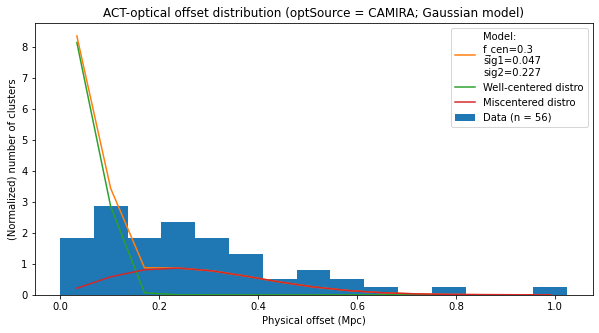

In [45]:
## Plot offset distro

plt.figure(figsize=(10,5))

plt.title(f"ACT-optical offset distribution (optSource = {optSource}; Gaussian model)")

## Data sample
num_bins = 16
max_offset = np.max(physical_offsets)
bins = np.linspace(0, max_offset, num=num_bins)
hist = plt.hist(physical_offsets, bins=bins, label=f"Data (n = {len(physical_offsets)})", \
               density=True)
plt.xlabel("Physical offset (Mpc)")
plt.ylabel("(Normalized) number of clusters")

## Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# plot full model
norm_factor_full = 1 / \
        integrate.quad(offset_model, 0, max_offset, args=(f_best, sig1_best, sig2_best))[0]
plt.plot(x_axis, norm_factor_full*offset_model(x_axis, f_best, sig1_best, sig2_best), label=\
    f"Model:\nf_cen={np.round(f_best,3)}\nsig1={np.round(sig1_best,3)}\nsig2={np.round(sig2_best,3)}")
# plot the model's two components separately
plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered distro")
plt.plot(x_axis, norm_factor_full*(1-f_best)*prob_dens_mis_centered(x_axis, sig2_best), 
         label=f"Miscentered distro")

plt.legend()
plt.show()

# Cross-matching HSC and ACT clusters

Below, we perform a cross-match between the two catalogs.

## Create the sample

In [11]:
# preliminary upper cutoff; corresponds to ~3 Mpc physical separation for z = 1.4
prelim_cutoff = 6 * u.arcmin

In [12]:
def remove_duplicates(idx, d2d, d3d):
    '''
    This function aims to remove duplicates from the results of an 
    asymmetric cross-match.
    
    Given idx, d2d, and d3d from astropy's match_to_catalog_sky function,
    return the 'good' indices in idx as a boolean array. (Here, bad means
    that an index in idx is matched to an object that already has a better 
    match in idx.)
    
    For example: if idx = (8, 8, 8) and d2d = (0.1, 0.3, 0.04), then we 
    accept the third element in idx and reject the two others. This 
    function then returns (False, False, True). 
    
    ARGUMENTS
    ---------
    idx, d2d, d3d: returns of astropy's match_to_catalog_sky function
    
    '''
    
    unique_idx, counts = np.unique(idx, return_counts=True)
    repeated_idxs = unique_idx[np.where(counts > 1)] # idxs appearing in idx multiple times
    not_duplicate = np.ones(idx.shape)
        
    for rep_idx in repeated_idxs:
        locs = np.where(idx == rep_idx)[0] # rep_idx's locations in idx
        locs = locs[d2d[locs] < prelim_cutoff]
        if len(locs) < 2: continue
        best_loc = locs[0]
        
        for loc in locs:
            if d2d[loc] < d2d[best_loc]: best_loc = loc
        for loc in locs:        
            if loc != best_loc: not_duplicate[loc] = 0
            
            if (d2d[loc] < prelim_cutoff):
                print(f'Cluster matched with HSC idx {rep_idx} (d2d = {np.round(d2d[loc],3)}):')
                print(ACT_cat[loc]['name'])
        if (d2d[best_loc] < prelim_cutoff):
            print()
    
    return not_duplicate == 1

In [13]:
# Note: idx indexes into HSC_coords
idx, d2d, d3d = ACT_coords.match_to_catalog_sky(HSC_coords)

within_radius = (d2d < prelim_cutoff)
not_duplicate = remove_duplicates(idx, d2d, d3d)
has_cam_richness = (ACT_cat['CAMIRA_N_mem'] != -99)
good_inds = within_radius & not_duplicate & has_cam_richness

print(f'Number of ACT clusters within the preliminary matching radius: {np.sum(within_radius)}')
print(f'Number of ACT clusters in (preliminary) reduced sample: {np.sum(good_inds)}')

Cluster matched with HSC idx 1912 (d2d = 0.084 deg):
ACT-CL J0935.0+0053
Cluster matched with HSC idx 1912 (d2d = 0.026 deg):
ACT-CL J0935.2+0048

Cluster matched with HSC idx 6783 (d2d = 0.028 deg):
ACT-CL J2343.7+0016
Cluster matched with HSC idx 6783 (d2d = 0.03 deg):
ACT-CL J2343.7+0018

Number of ACT clusters within the preliminary matching radius: 220
Number of ACT clusters in (preliminary) reduced sample: 208


In [37]:
in_footprint_no_crossmatch = ACT_cat[in_hsc_footprint & ~good_inds]['name']

print('Number of ACT clusters in HSC footprint (but excluded from the cross-match): ' + 
      str(len(in_footprint_no_crossmatch)))
# print('Names of those ACT clusters:')
# print(in_footprint_no_crossmatch)

Number of ACT clusters in HSC footprint (but excluded from the cross-match): 21


In [26]:
## Clusters that are: 
# 1. in the HSC footprint,
# 2. aren't in the crossmatch, but 
# 3. are flagged as having a counterpart

np.setdiff1d(in_footprint_no_crossmatch, \
             in_footprint_no_counterpart)

ACT-CL J0218.1-0214
ACT-CL J0935.0+0053
ACT-CL J1020.3-0100
ACT-CL J2343.7+0018


In [35]:
cl_names = ['ACT-CL J0218.1-0214', 'ACT-CL J1020.3-0100']

ACT_cat[np.where(ACT_cat['name'] == cl_names[0])]

name,RADeg,decDeg,SNR,y_c,err_y_c,fixed_SNR,fixed_y_c,fixed_err_y_c,template,tileName,redshift,redshiftErr,redshiftType,redshiftSource,M500c,M500c_errPlus,M500c_errMinus,M500cCal,M500cCal_errPlus,M500cCal_errMinus,M200m,M200m_errPlus,M200m_errMinus,M500cUncorr,M500cUncorr_errPlus,M500cUncorr_errMinus,M200mUncorr,M200mUncorr_errPlus,M200mUncorr_errMinus,footprint_DESY3,footprint_HSCs19a,footprint_KiDSDR4,zCluster_delta,zCluster_errDelta,zCluster_source,RM,RM_LAMBDA,RM_LAMBDA_ERR,RMDESY3,RMDESY3_LAMBDA_CHISQ,RMDESY3_LAMBDA_CHISQ_E,CAMIRA,CAMIRA_N_mem,opt_RADeg,opt_decDeg,opt_positionSource,notes,knownLens,knownLensRefCode,warnings
bytes19,float64,float64,float64,float64,float64,float64,float64,float64,bytes25,bytes7,float64,float64,bytes1000,bytes1000,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,bytes12,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,bytes10,bytes26,bytes42,bytes14,bytes93
ACT-CL J0218.1-0214,34.52511700467782,-2.2391972694274394,5.332904153633143,0.4862711306698901,0.09118317461951919,5.328942266571874,0.47658016708145406,0.08943241327101853,Arnaud_M8e14_z0p8,1_10_4,1.1624,0.030273599999999998,phot,zCluster,1.6035795495300924,0.315695925117335,0.26376803959376877,2.2585627458170316,0.4972835053063983,0.43312778220057924,2.720342246751998,0.5355524535566707,0.44746102035296487,1.8027088572577656,0.3683103532079881,0.30582702020649094,3.065562616254189,0.6263232387349056,0.5200683828733068,True,True,False,2.850196608943242,0.62,DECaLS-Prior,False,-99.0,-99.0,False,-99.0,-99.0,True,12.249,34.52033952913912,-2.238559096451313,Vis-BCG,Lensing?,,,Low delta zCluster redshift


In [36]:
ACT_cat[np.where(ACT_cat['name'] == cl_names[1])]

name,RADeg,decDeg,SNR,y_c,err_y_c,fixed_SNR,fixed_y_c,fixed_err_y_c,template,tileName,redshift,redshiftErr,redshiftType,redshiftSource,M500c,M500c_errPlus,M500c_errMinus,M500cCal,M500cCal_errPlus,M500cCal_errMinus,M200m,M200m_errPlus,M200m_errMinus,M500cUncorr,M500cUncorr_errPlus,M500cUncorr_errMinus,M200mUncorr,M200mUncorr_errPlus,M200mUncorr_errMinus,footprint_DESY3,footprint_HSCs19a,footprint_KiDSDR4,zCluster_delta,zCluster_errDelta,zCluster_source,RM,RM_LAMBDA,RM_LAMBDA_ERR,RMDESY3,RMDESY3_LAMBDA_CHISQ,RMDESY3_LAMBDA_CHISQ_E,CAMIRA,CAMIRA_N_mem,opt_RADeg,opt_decDeg,opt_positionSource,notes,knownLens,knownLensRefCode,warnings
bytes19,float64,float64,float64,float64,float64,float64,float64,float64,bytes25,bytes7,float64,float64,bytes1000,bytes1000,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,bytes12,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,bytes10,bytes26,bytes42,bytes14,bytes93
ACT-CL J1020.3-0100,155.08741276595887,-1.0166666666666626,4.3218433543809684,0.7761908677895246,0.17959717744112938,4.208696323900061,0.5130039973374592,0.12189142619396097,Arnaud_M2e14_z0p8,3_0_2,0.41099557280540466,0.01617961749434471,phot,redMaPPer,1.8709975005099093,0.47568343648178346,0.37926013147416904,2.6352077471970556,0.7185885942354354,0.5940013142939703,3.3143452750146363,0.8426409707530093,0.6718336205207477,2.132499258792534,0.5643587786966231,0.44625807533573125,3.78856940181978,1.002632189344371,0.7928160737036954,False,True,False,1.1189115309986017,0.2,DECaLS,True,35.59407043457031,4.302978515625,False,-99.0,-99.0,True,10.447,155.086439,-1.005273,CAMIRA,,,,


## Compute offsets and model the distribution

Within this cross-matched sample, compare the distributions of the HSC catalog's N_mem values and the ACT catalog's N_mem values.

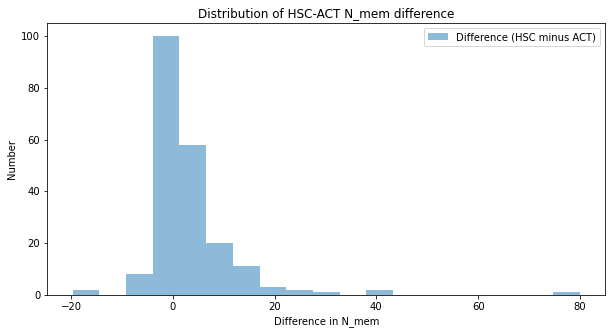

In [54]:
## (just a test) investigate differences in richnesses
N_mem_from_HSC = HSC_cat[idx[good_inds],3]
N_mem_from_ACT = ACT_cat[good_inds]['CAMIRA_N_mem']
N_mem_diffs = N_mem_from_HSC - N_mem_from_ACT

## histograms of N_mem for HSC vs. ACT
plt.figure(figsize=(10,5))
plt.title(f"Distribution of HSC-ACT N_mem difference")

num_bins = 20
bins = np.linspace(min(N_mem_diffs), max(N_mem_diffs), num=num_bins)
plt.hist(N_mem_diffs, bins=bins, \
                 alpha=0.5, label='Difference (HSC minus ACT)')
plt.xlabel('Difference in N_mem')
plt.ylabel('Number')

plt.legend()
plt.show()

In [60]:
## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)

angular_sep = ACT_coords[good_inds].separation(\
                        HSC_coords[idx[good_inds]])
redshifts = ACT_cat[good_inds]['redshift']
physical_sep = get_physical_sep(cosmo, angular_sep, redshifts)

# impose upper limit on offsets
limit = 1 * u.Mpc / h
below_offset_limit = (physical_sep < limit)
offsets_Mpc = physical_sep[below_offset_limit]

# (a test on how f_cen varies; needs to be updated for richnesses) 
# remove the x largest offsets
remove_offsets = False
if remove_offsets:
    offsets_Mpc.sort()
    print(f'Largest offsets: {offsets_Mpc[-3:]}')

    f_excluded = 1 - len(offsets_Mpc) / len(physical_sep)
    print(f'Percent of offsets excluded: {np.round(f_excluded * 100, 2)}%')

## Fit the model
physical_offsets = offsets_Mpc.value # "offsets" is unitless

# (a test on how f_cen varies; needs to be updated for richnesses) 
# inject large offsets into the distribution
inject_offsets = False
if inject_offsets:
    fake_offsets = np.linspace(0.5, 1.2, num=0)
    scaled_offsets = np.concatenate((offsets, fake_offsets))
    print(f'len(offsets): {len(offsets)}')

initial_guess = (0.75, 0.03, 0.17)
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(physical_offsets), \
                     method='L-BFGS-B', bounds=((0., 1), (1e-4, 0.3), (0.1, 1.)))

init_obj = objective_fn(initial_guess, physical_offsets)
#print(f'Initial obj: {init_obj}\n')

f_best, sig_best, tau_best = best_guess.x
print(best_guess)

      fun: -271.3761880344072
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00031264, -0.00435421,  0.00136993])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 56
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([0.5906319 , 0.0877702 , 0.28579948])


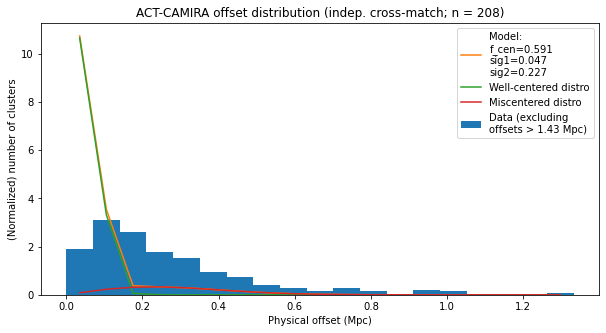

In [62]:
## Plot offset distribution (cross-match)
plt.figure(figsize=(10,5))
plt.title(f"ACT-CAMIRA offset distribution (indep. cross-match; n = {len(physical_offsets)})")

## Data sample
num_bins = 20
bins = np.linspace(0, np.max(physical_offsets), num=num_bins)
hist = plt.hist(physical_offsets, bins=bins, \
                label=f"Data (excluding\noffsets > {np.round(limit,2)})", density=True)
plt.xlabel("Physical offset (Mpc)")
plt.ylabel("(Normalized) number of clusters")

## Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# plot full model
norm_factor_full = 1 / \
        integrate.quad(offset_model, 0, max_offset, args=(f_best, sig1_best, sig2_best))[0]
plt.plot(x_axis, norm_factor_full*offset_model(x_axis, f_best, sig1_best, sig2_best), label=\
    f"Model:\nf_cen={np.round(f_best,3)}\nsig1={np.round(sig1_best,3)}\nsig2={np.round(sig2_best,3)}")
# plot the model's two components separately
plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered distro")
plt.plot(x_axis, norm_factor_full*(1-f_best)*prob_dens_mis_centered(x_axis, sig2_best), 
         label=f"Miscentered distro")

plt.legend()
plt.show()

## Investigating why the well-centered fraction is low

Below, we make fake distributions and check that the model recovers the well-centered fraction.

In [216]:
## test model on fake distributions
temp1 = np.ones(30) * 0.1
temp2 = np.ones(20) * 0.2
temp3 = np.ones(15) * 0.9
temp4 = np.ones(35) * 1.3
temp_offsets = np.concatenate((temp1, temp2, temp3, temp4))

## Fit the model
initial_guess = (0.68, 0.066, 0.37)
# Nelder-Mead is the only method in scipy.optimize.minimize that yields reasonable results
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(temp_offsets), \
                     method='Nelder-Mead')

init_obj = objective_fn(initial_guess, offsets)
print(f'Initial obj: {init_obj}\n')

f_best, sig1_best, sig2_best = best_guess.x
print(best_guess)

Initial obj: 9.170846701680917e-171

 final_simplex: (array([[0.46022196, 0.08346289, 0.66423919],
       [0.46026881, 0.08346595, 0.66416856],
       [0.46029849, 0.08345663, 0.66430119],
       [0.46020704, 0.08345168, 0.66418825]]), array([9.36882645e-46, 9.36883815e-46, 9.36883894e-46, 9.36884040e-46]))
           fun: 9.368826451721663e-46
       message: 'Optimization terminated successfully.'
          nfev: 110
           nit: 61
        status: 0
       success: True
             x: array([0.46022196, 0.08346289, 0.66423919])


# Plotting info from TOPCAT 

## Number of matches vs. matching radius

I got the data below via TOPCAT's table-matching feature. I selected "Best match, symmetric" and "1 and 2" for Match Selection and Join Type, respectively. Then, I plugged in different matching radii using the Max error option.

In [2]:
## Plotting number of matches vs. match radius
# match_radius = [.1, .2, .3, .4, .5, \
#                 .6, .7, .8, .9, 1, \
#                1.1, 1.2, 1.3, 1.4, 1.5, \
#                2, 2.5, 3, 4, 5, 6, 7, \
#                10, 15] # arcmin
# num_matches = [6, 34, 48, 71, 94, \
#                107, 123, 142, 149, 157, \
#               162, 167, 170, 175, 178,
#               187, 190, 194, 201, 205, 210, 215, \
#               234, 247]

# plt.scatter(match_radius, num_matches)
# plt.xlabel('Matching radius (arcminutes)')
# plt.ylabel('Number of matches')

# plt.show()

# Plot clusters on the sky

Reference: https://het.as.utexas.edu/HET/Software/Astropy-1.0/coordinates/skycoord.html#example-1-plotting-random-data-in-aitoff-projection

## Plot full catalogs

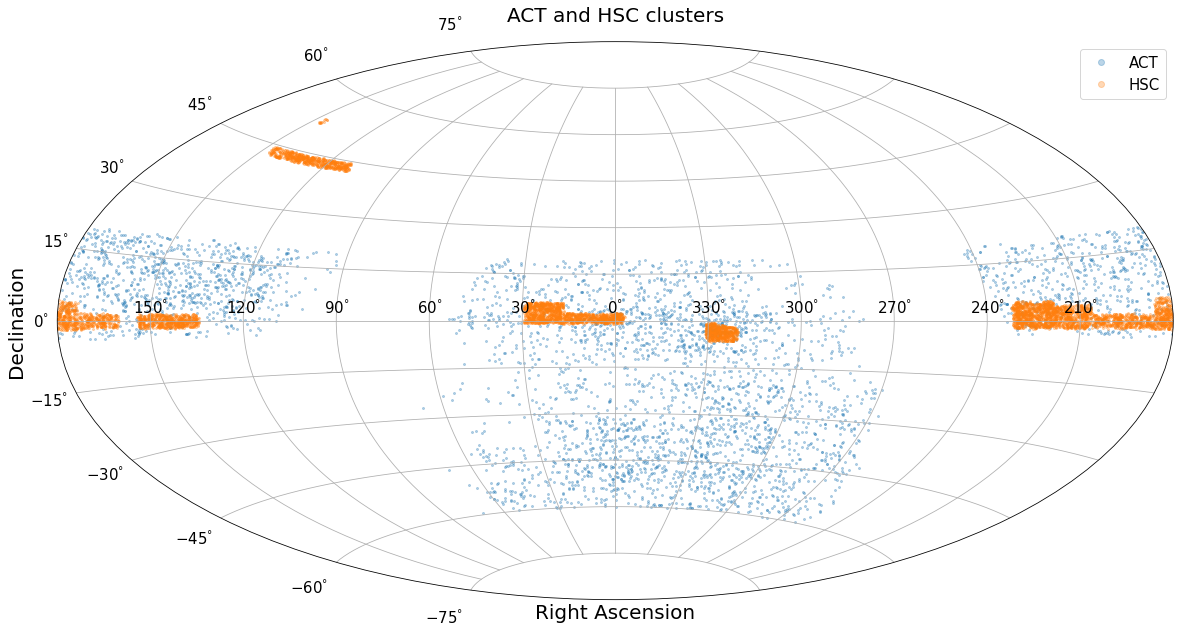

In [50]:
fig = plt.figure(figsize=(20,13))
fig.patch.set_facecolor('white')

ax = plt.subplot(111, projection="aitoff")
ax.grid(True)
ax.plot(act_ra, act_dec, 'o', markersize=2, alpha=0.3, label='ACT', zorder=1)
ax.plot(hsc_ra, hsc_dec, 'o', markersize=2, alpha=0.3, label='HSC', zorder=1)

ax.set_xlabel('Right Ascension', fontsize=20)
ax.set_ylabel('Declination', fontsize=20)
tick_labels_x = np.array([r'$150^\degree$', r'$120^\degree$', r'$90^\degree$', r'$60^\degree$', 
                        r'$30^\degree$', r'$0^\degree$', r'$330^\degree$', r'$300^\degree$',
                        r'$270^\degree$', r'$240^\degree$', r'$210^\degree$'])
tick_labels_y = np.array([r'$-75^\degree$', r'$-60^\degree$', r'$-45^\degree$', r'$-30^\degree$', 
                        r'$-15^\degree$', r'$0^\degree$', r'$15^\degree$', r'$30^\degree$',
                        r'$45^\degree$', r'$60^\degree$', r'$75^\degree$'])
ax.set_xticklabels(tick_labels_x, fontsize = 15, zorder = 5)
ax.set_yticklabels(tick_labels_y, fontsize = 15, zorder = 5)

ax.set_title("ACT and HSC clusters", pad=20, fontsize=20)
ax.legend(fontsize=15, markerscale=3)
plt.savefig("/Figures/Catalog_Props/ACT_HSC_catalogs_on_sky.png", bbox_inches='tight')
plt.show()

## Plot a random subset of ACT clusters

(playing around with matplotlib)

In [1]:
# size = len(act_ra)
# rand_inds = np.random.uniform(size=size) > 0.98

# fig = plt.figure(figsize=(16,10))

# ax = plt.subplot(111, projection="aitoff")
# ax.set_facecolor('#C3FFFF')
# plt.grid(True)
# # unicode 00a9 = copyright symbol
# plt.plot(act_ra[rand_inds], act_dec[rand_inds], marker='$\u00A9$', 
#          markersize=20, linestyle='None', alpha=0.5, label='ACT', c='r')

# plt.title("Random ~2% of ACT galaxy clusters", pad=25)
# plt.show()

## Plot ACT clusters cross-matched with HSC, SDSS, and/or DES

Number of ACT clusters cross-matched with CAMIRA (HSC): 212
Number of ACT clusters cross-matched with redMaPPer (SDSS and/or DES): 2510
Number of ACT clusters cross-matched with at least one of the catalogs: 2600



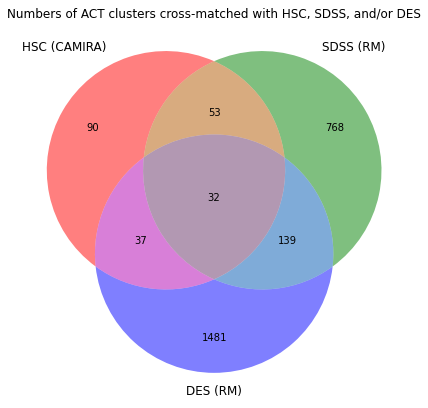

In [49]:
## Separate RM clusters based on if they have a counterpart:
# 1. only in one catalog,
# 2. in two catalogs, or 
# 3. in all three

has_hsc_counterpart = ACT_cat['CAMIRA']
has_sdss_counterpart = ACT_cat['RM'] 
has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with CAMIRA (HSC): ' + 
      str(np.sum(has_hsc_counterpart)))
print('Number of ACT clusters cross-matched with redMaPPer (SDSS and/or DES): ' + 
      str(np.sum(has_sdss_counterpart | has_des_counterpart)))
print('Number of ACT clusters cross-matched with at least one of the catalogs: ' + 
      str(np.sum(has_hsc_counterpart | has_sdss_counterpart | has_des_counterpart)))

print()

hsc_only = has_hsc_counterpart & (~has_sdss_counterpart) & (~has_des_counterpart)
sdss_only = (~has_hsc_counterpart) & has_sdss_counterpart & (~has_des_counterpart)
des_only = (~has_hsc_counterpart) & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss = has_hsc_counterpart & has_sdss_counterpart & (~has_des_counterpart)
sdss_des = (~has_hsc_counterpart) & has_sdss_counterpart & has_des_counterpart
hsc_des = has_hsc_counterpart & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss_des = has_hsc_counterpart & has_sdss_counterpart & has_des_counterpart

# 3-group Venn diagram showing #s of clusters in each category
from matplotlib_venn import venn3_unweighted

# order of subsets: A, B, AB, C, AC, BC, ABC
subsets = (np.sum(hsc_only), np.sum(sdss_only), np.sum(hsc_sdss), \
          np.sum(des_only), np.sum(hsc_des), np.sum(sdss_des), \
          np.sum(hsc_sdss_des))

plt.figure(figsize=(7,7))
plt.title("Numbers of ACT clusters cross-matched with HSC, SDSS, and/or DES")
venn3_unweighted(subsets = subsets, \
      set_labels = ('HSC (CAMIRA)', 'SDSS (RM)', 'DES (RM)'), \
      alpha = 0.5)

plt.savefig("/Figures/Catalog_Props/HSC_SDSS_DES_Venn.png", bbox_inches='tight')
plt.show()

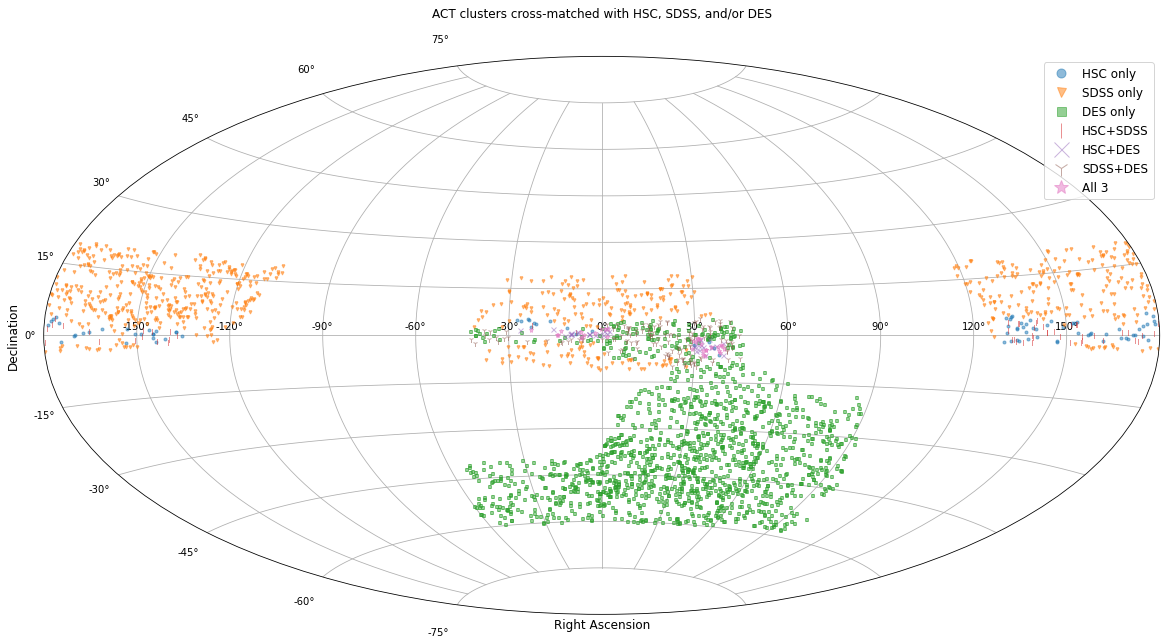

In [48]:
## Plot the different subsets

plt.figure(figsize=(20,13))

plt.subplot(111, projection="aitoff")
plt.grid(True)

plt.plot(act_ra[hsc_only], act_dec[hsc_only], 
         'o', markersize=3, alpha=0.5, label='HSC only')
plt.plot(act_ra[sdss_only], act_dec[sdss_only], 
         'v', markersize=3, alpha=0.5, label='SDSS only')
plt.plot(act_ra[des_only], act_dec[des_only], 
         's', markersize=3, alpha=0.5, label='DES only')

plt.plot(act_ra[hsc_sdss], act_dec[hsc_sdss], 
         '|', markersize=5, alpha=0.5, label='HSC+SDSS')
plt.plot(act_ra[hsc_des], act_dec[hsc_des], 
         'x', markersize=5, alpha=0.5, label='HSC+DES')
plt.plot(act_ra[sdss_des], act_dec[sdss_des], 
         '1', markersize=5, alpha=0.5, label='SDSS+DES')

plt.plot(act_ra[hsc_sdss_des], act_dec[hsc_sdss_des], 
         '*', markersize=5, alpha=0.5, label='All 3')

plt.xlabel('Right Ascension', fontsize=12)
plt.ylabel('Declination', fontsize=12)

plt.title("ACT clusters cross-matched with HSC, SDSS, and/or DES", pad=40)
plt.legend(fontsize=12, markerscale=3)
plt.show()